In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf
import datetime

ticker = 'SPY'
today = datetime.date.today()
past = datetime.date(2023, 8, 1)
data_interval = '1h'

In [124]:
class StockData:
    def __init__(self, ticker_name, start_date, end_date, interval_time):
        import plotly.graph_objects
        import yfinance
        OHLC = ["Open", "High", "Low", "Close"]
        if interval_time == "1h":
            candlestick_rangebreaks = [ 
                { 'values': ['2023-01-02', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04', '2023-09-04']},
                { 'pattern': 'day of week', 'bounds': ['sat', 'mon']},
                { 'pattern': 'hour', 'bounds':[16,9.5]}
            ]
            line_rangebreaks = [ 
                { 'pattern': 'day of week', 'bounds': ['sat', 'mon']},
                { 'pattern': 'hour', 'bounds':[16,9.5]}
            ]
        elif interval_time == "1d":
            candlestick_rangebreaks = [ 
                { 'values': ['2023-01-02', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04', '2023-09-04'] },
                { 'pattern': 'day of week', 'bounds': ['sat', 'mon']},
            ]
            line_rangebreaks = [ 
                { 'pattern': 'day of week', 'bounds': ['sat', 'mon']}
            ]
        
        self.history = yfinance.Ticker(ticker_name).history(
                start = start_date, 
                end = end_date,
                interval = interval_time
            )
        self.candlestick = plotly.graph_objects.Figure(
            data=[
                plotly.graph_objects.Candlestick(
                    x=self.history.index,
                    open=self.history['Open'],
                    high=self.history['High'],
                    low=self.history['Low'],
                    close=self.history['Close']
                )
            ]
        )
        self.candlestick.update_xaxes(
            rangebreaks=candlestick_rangebreaks
        )
        self.line = plotly.graph_objects.Figure(
            data=[
                plotly.graph_objects.Scatter(
                    x=self.history.index,
                    y=self.history['High'],
                    name = "High"
                ),
                plotly.graph_objects.Scatter(
                    x=self.history.index,
                    y=self.history['Low'],
                    name = "Low"
                ),
                plotly.graph_objects.Scatter(
                    x=self.history.index,
                    y=self.history['Close'],
                    name = "Close"
                    
                )                
            ]
        )
        self.line.update_xaxes(
            rangebreaks=line_rangebreaks
        )

In [125]:

StockData('SPY', start_date=past, end_date=today, interval_time='1h').candlestick

c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:633: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:634: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:638: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\U

In [126]:
def GenerateTestPeriodWeeks(starting_date, end_date):
    test_periods = []
    period_start = starting_date
    for period in range((abs(starting_date - end_date).days) // 7):
        period_end = period_start + datetime.timedelta(days=4)
        test_periods.append([period_start, period_end])
        period_start = period_start + datetime.timedelta(days=7)
    return test_periods

<Axes: >

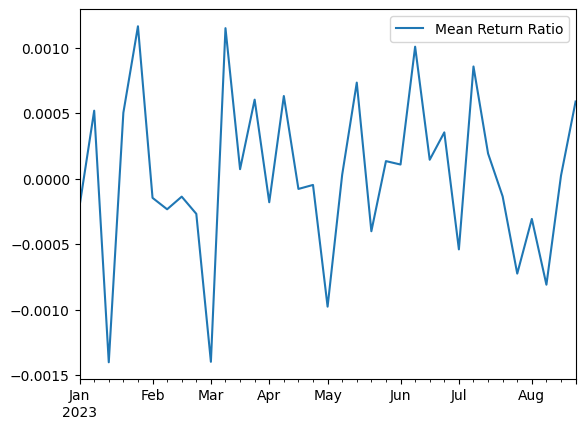

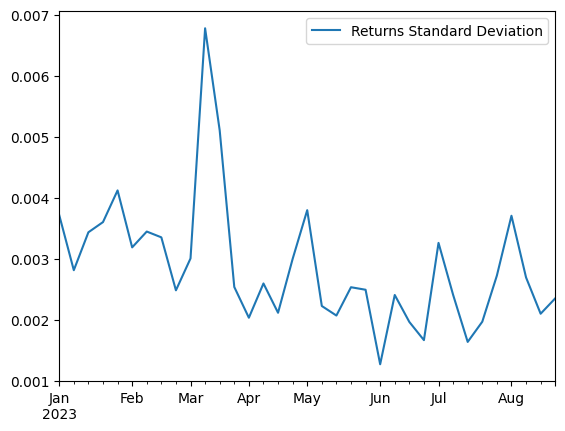

In [127]:
test_periods = GenerateTestPeriodWeeks(datetime.date(2023,1,2), today)
average_array = []
index_label_array = []
stddev_array = []
print()

for plot_index, period in enumerate(test_periods):
    stock = StockData(ticker_name='SPY', start_date=period[0], end_date=period[1], interval_time='1h')
    weekly_data = stock.history['Close'].values.tolist()
    weekly_ratios = []
    for index, interval in enumerate(weekly_data):
        if index >= 1:
            ratio = np.log(weekly_data[index]/weekly_data[index-1])
            weekly_ratios.append(ratio)
    # plt.hist(weekly_ratios)
    # plt.title("Stock Return Distribution for {} to {}, {} incr.".format(period[0], period[1], '1h'))
    # plt.xlabel("Occurences")
    # plt.ylabel("Fractional Returns")
    # plt.show()

    average_array.append(np.mean(weekly_ratios))
    stddev_array.append(np.std(weekly_ratios))
    index_label_array.append(period[0])
    index_label_datetimeindex = pd.DatetimeIndex(index_label_array)

mean_return_ratio_df = pd.DataFrame({'Mean Return Ratio':average_array}).set_index(index_label_datetimeindex)
mean_return_ratio_df.plot()

stddev_return_ratio_df = pd.DataFrame({'Returns Standard Deviation':stddev_array}).set_index(index_label_datetimeindex)
stddev_return_ratio_df.plot()




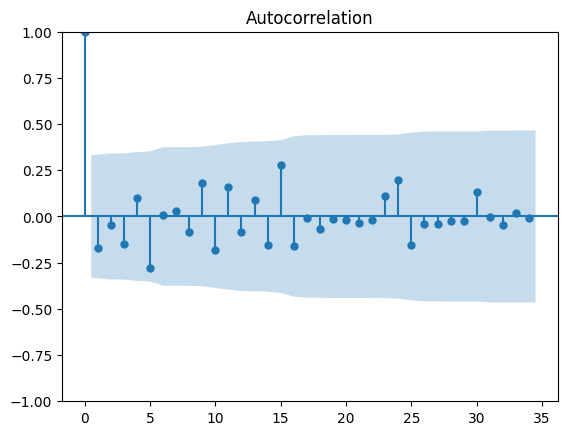

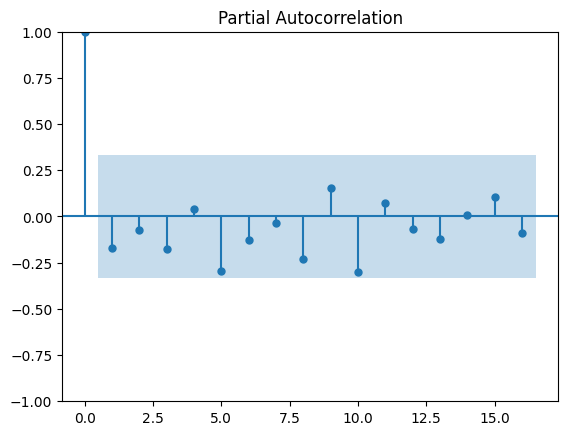

In [139]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lags_acf = len(average_array) - 1
max_lags_pacf = max_lags_acf//2 - 1

mean_acf = plot_acf(average_array, lags = max_lags_acf)
mean_pacf = plot_pacf(average_array, lags = max_lags_pacf)

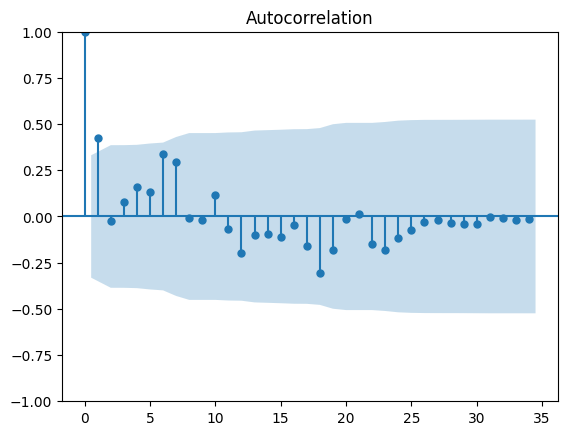

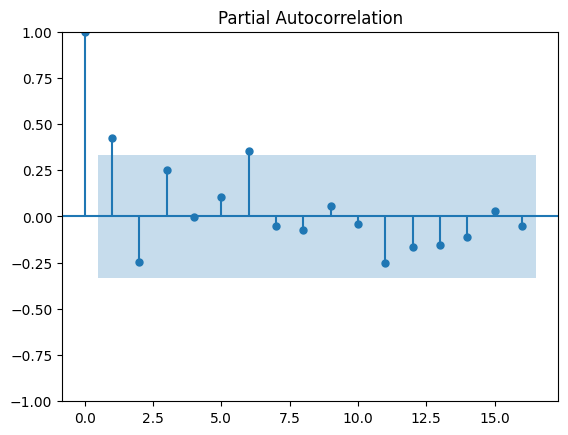

In [140]:
stddev_acf = plot_acf(stddev_array, lags = max_lags_acf)
stddev_pacf = plot_pacf(stddev_array, lags = max_lags_pacf)

In [161]:
from statsmodels.tsa.arima.model import ARIMA

arima_returns_model = ARIMA(average_array, order = (2, 1, 0))
fitted_returns_model = arima_returns_model.fit()
print(fitted_returns_model.summary())

strt = len(average_array)//2 - 1
predicted_returns_array = fitted_returns_model.predict(start=strt, end=(len(average_array)-1), dynamic = True)
print(predicted_returns_array)

actual_vs_prediction_df = pd.concat([average_array, predicted_returns_array], axis = 'columns')
actual_vs_prediction_df.plot()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 195.382
Date:                Sat, 09 Sep 2023   AIC                           -384.763
Time:                        20:58:58   BIC                           -380.184
Sample:                             0   HQIC                          -383.201
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6824      0.183     -3.727      0.000      -1.041      -0.324
ar.L2         -0.2897      0.214     -1.354      0.176      -0.709       0.130
sigma2      5.818e-07   1.76e-07      3.311      0.0

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid